In [11]:
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

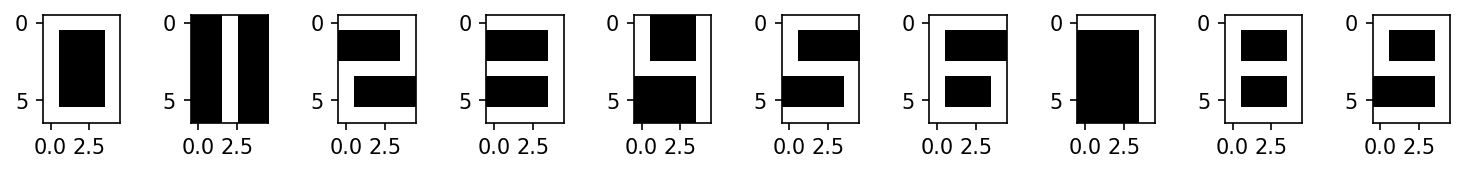

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_figwidth(10)
fig.set_dpi(150)

nums_mtrx =  np.loadtxt(Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(7, 5), cmap='gray')

plt.tight_layout()
plt.show()

In [13]:
cells_columns = [f'c{n}' for n in range(35)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.25, 35)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [14]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0 : test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size : p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

xTest = np.array(df.iloc[idx_test][features_columns])
yTest = np.array(df.iloc[idx_test][label_columns])

xTrain = np.array(df.iloc[idx_train][features_columns])
yTrain = np.array(df.iloc[idx_train][label_columns])

In [15]:
@njit(fastmath=True)
def ReLU(x: np.ndarray, p: np.ndarray, q: np.ndarray) -> np.ndarray:
    return p * x * (x >= 0) + q * x * (x < 0)

@njit(fastmath=True)
def dReLU(x: np.ndarray, p: np.ndarray, q: np.ndarray) -> np.ndarray:
    return p * (x >= 0) + q * (x < 0)

@njit(fastmath=True)
def dReLU_dp(x: np.ndarray) -> np.ndarray:
    return x * (x >= 0)

@njit(fastmath=True)
def dReLU_dq(x: np.ndarray) -> np.ndarray:
    return x * (x < 0)

@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)

@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

In [16]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, W: np.ndarray, b: np.ndarray, p: np.ndarray, q: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    dp = np.zeros(p.shape)
    dq = np.zeros(q.shape)

    h = np.zeros((W.shape[0], W.shape[1]))
    u = np.zeros(W.shape[1])
    
    for i in prange(xBatch.shape[0]):
        u *= 0

        for j in range(W.shape[0]):
            h[j] = W[j] @ xBatch[i] + b[j]
            u += ReLU(h[j], p[j], q[j])

        y = softmax(u)

        for j in range(W.shape[0]):
            dLdu = (y - yBatch[i])
            dLdh = dLdu * dReLU(h[j], p[j], q[j])

            dW[j] += np.outer(dLdh, xBatch[i])
            db[j] += dLdh

            dp[j] += dLdu * dReLU_dp(h[j])
            dq[j] += dLdu * dReLU_dq(h[j])
                
    return (dW, db, dp, dq)


class WidePerceptron:
    def __init__(self, nIn: int, nL:int, nOut: int) -> None:
        self.nIn = nIn
        self.nL = nL
        self.nOut = nOut
        
        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))
        self.b: np.ndarray = np.zeros((nL, nOut))

        self.p = np.zeros((nL, nOut))
        self.q = np.zeros((nL, nOut))

    def predict(self, x:np.ndarray) -> np.ndarray:
        y = np.zeros(self.nOut)

        for i in range(self.nL):
            h = self.W[i] @ x + self.b[i]
            y += ReLU(h, self.p[i], self.q[i])

        return softmax(y)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n//batch_size):
                ibegin, iend = batch_idx*batch_size, min((batch_idx+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]
            
                dW, db, dp, dq = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.W, self.b, self.p, self.q)

                self.W -= lr * dW
                self.b -= lr * db

                self.p -= lr * dp
                self.q -= lr * dq
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(Ypred), axis=1)
        return np.mean(h)

In [43]:
nIn = 35
nL = 3
nOut = 10

learning_rate = 1e-2
batch_size = 8
max_epoch = 100

model = WidePerceptron(nIn, nL, nOut)

print('untrained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

model.train(xTrain, yTrain, learning_rate, batch_size, max_epoch)

print('trained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

true_pos_count = 0
for x, y in zip(xTest, yTest):
    yPred = model.predict(x)
    true_pos_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = true_pos_count / xTest.shape[0]
print(f"test set accuracy: {round(accuracy*100, 2)}%")

untrained loss: 0.230259
trained loss: 0.003856
test set accuracy: 100.0%


In [44]:
n_samples = 10000
noise_amplitude = 1.0

true_pos_count = 0

for i in range(n_samples):
    j = i % 10
    x = nums_mtrx[j] + np.random.uniform(0, noise_amplitude, 35)
    yPred = model.predict(x)
    true_pos_count += 1 if j == np.argmax(yPred) else 0

print(f"accuracy: {round(true_pos_count/n_samples*100, 2)}% ({true_pos_count} of {n_samples})")

accuracy: 71.2% (7120 of 10000)


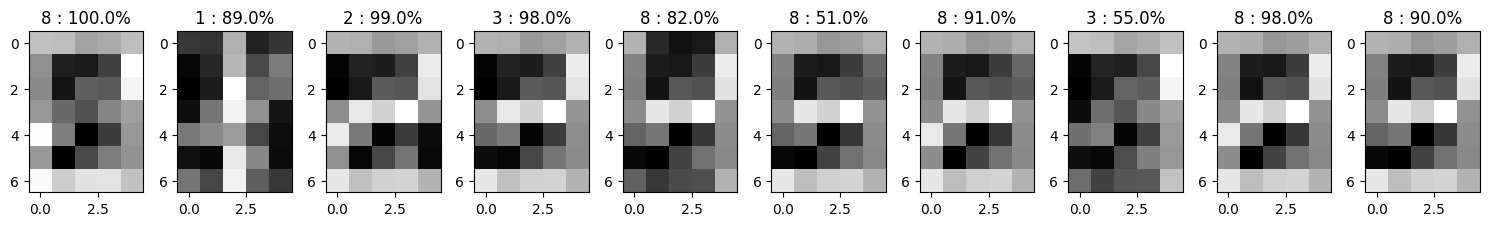

In [45]:
x_noised = nums_mtrx + np.random.uniform(0, 1.0, 35)

yPred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape((7, 5)),  cmap='gray')
    j = np.argmax(yPred[i])
    ax.set_title(f"{j} : {(yPred[i][j]*100).round()}%")

plt.autoscale()
plt.tight_layout()
plt.show()

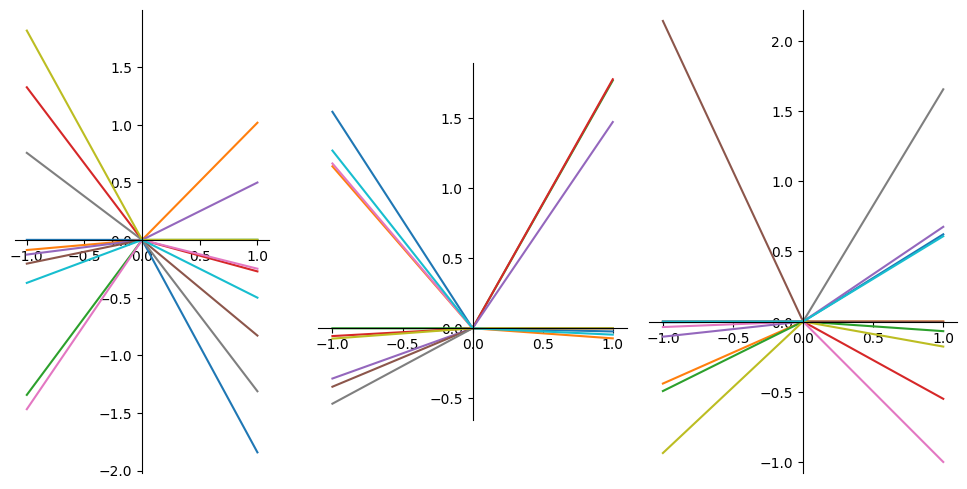

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=nL)

fig.set_dpi(100)
fig.set_figwidth(10)
fig.set_figheight(5)

x = np.linspace(-1, 1, 100)

for i, ax in enumerate(axes.ravel()):
    for a, b in zip(model.p[i], model.q[i]):
        y = (x >= 0) * a * x + (x < 0) * b * x
        ax.plot(x,y)
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('zero')
        ax.set_aspect('equal', adjustable='box')

plt.axis('equal')
plt.tight_layout()
plt.show()